<a href="https://colab.research.google.com/github/mtsizh/galaxy-morphology-manifold-learning/blob/main/synthetic_3d_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Few libraries are not installed by default.

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

try:
  from cuml.manifold import TSNE
  from cuml.manifold import UMAP
  from cuml.decomposition import PCA
  from google.colab import output
  output.clear()
except:
  print('ERROR')
finally:
  print('COMPLETE')

COMPLETE


In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from cuml.manifold import UMAP
from cuml.decomposition import PCA
from tqdm.auto import tqdm
from PIL import Image
import pickle



class_map = {0: 'round', 1: 'inbetween', 2: 'cigar'}
n_bootstrap_samples = 6000


def gaussian_profile(r2):
  return np.exp(-r2)

def schuster_profile(r2):
  return np.power(1+r2, -2.5)

#https://galaxiesbook.org/chapters/III-01.-Triaxial-Mass-Distributions.html
def vaucouleurs_profile(r):
  return np.exp(-7.67*(r**(1/4)-1))

def sersic_profile(r, b, n):
  return np.exp(-b*(r**(1/n)-1))


def get_data(num_images=500, image_size=(120, 120), gray_background=100, profile_fn=schuster_profile):
  X = np.zeros((num_images, image_size[0], image_size[1]), dtype=np.uint8)
  Y = np.zeros(num_images, dtype=np.uint8)
  for i in range(num_images):
    img = np.full(image_size, gray_background, dtype=np.float32)
    center_x = 60
    center_y = 60
    axes_x = 5 + np.random.randint(1, 50)
    axes_y = 5 + np.random.randint(1, 50)
    angle_rad = np.radians(np.random.randint(0, 180))
    eccentricity = np.sqrt(1 - (min(axes_x, axes_y) / max(axes_x, axes_y)) ** 2)

    e = [0.5, 0.8]
    Y[i] = np.searchsorted(e, eccentricity, side='right')
    x, y = np.meshgrid(np.arange(image_size[0]), np.arange(image_size[1]), indexing='ij')
    x -= center_x
    y -= center_y
    r2 = ((x * np.cos(angle_rad) + y * np.sin(angle_rad)) / axes_x)**2 + ((x * np.sin(angle_rad) - y * np.cos(angle_rad)) / axes_y)**2
    img += 155 * profile_fn(r2)
    img = np.clip(img, 0, 255).astype(np.uint8)
    X[i] = img

  return X, Y

X, y = get_data(num_images=n_bootstrap_samples)
X_flattened = X.reshape(X.shape[0], -1)


reduction_methods = {
    'TSNE': TSNE(n_components=3, perplexity=50),
    'UMAP': UMAP(n_components=3, n_neighbors=30, min_dist=0.1, metric='euclidean'),
    'ISO': Isomap(n_neighbors=30, n_components=3),
    'PCA': PCA(n_components=3),
    'LLE': LocallyLinearEmbedding(n_neighbors=30, n_components=3)
}

for name, method in reduction_methods.items():
  print(f'CALCULATE {name}')
  X_embedded = method.fit_transform(X_flattened)
  cname = '_'.join(class_map.values())
  out_file = f'{cname}_{name}_synthetic_3D.pkl'.replace(' ', '_')
  print('SAVING to: ', out_file)
  with open(out_file, 'wb') as f:
    pickle.dump({'X_embedded': X_embedded, 'y': y, 'class_map': class_map}, f)
print('COMPLETE')

CALCULATE TSNE
SAVING to:  round_inbetween_cigar_TSNE_synthetic_3D.pkl
CALCULATE UMAP
SAVING to:  round_inbetween_cigar_UMAP_synthetic_3D.pkl
CALCULATE ISO
SAVING to:  round_inbetween_cigar_ISO_synthetic_3D.pkl
CALCULATE PCA
SAVING to:  round_inbetween_cigar_PCA_synthetic_3D.pkl
CALCULATE LLE
SAVING to:  round_inbetween_cigar_LLE_synthetic_3D.pkl
COMPLETE


You can download precomputed embeddings




In [1]:
embeddings = [
  'round_inbetween_cigar_ISO_synthetic_3D.pkl',
  'round_inbetween_cigar_LLE_synthetic_3D.pkl',
  'round_inbetween_cigar_PCA_synthetic_3D.pkl',
  'round_inbetween_cigar_TSNE_synthetic_3D.pkl',
  'round_inbetween_cigar_UMAP_synthetic_3D.pkl'
]
for embedding in embeddings:
  print(f'downloading {embedding}')
  !wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/embeddings/{embedding} && echo "OK" || echo "FAIL"


downloading round_inbetween_cigar_ISO_synthetic_3D.pkl
OK
downloading round_inbetween_cigar_LLE_synthetic_3D.pkl
OK
downloading round_inbetween_cigar_PCA_synthetic_3D.pkl
OK
downloading round_inbetween_cigar_TSNE_synthetic_3D.pkl
OK
downloading round_inbetween_cigar_UMAP_synthetic_3D.pkl
OK


Draw the final result

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import plotly.express as px

# set correct filename to load embedding data
load_from = '/content/round_inbetween_cigar_LLE_synthetic_3D.pkl'


with open(load_from, 'rb') as f:
  data = pickle.load(f)
  X_embedded = data['X_embedded']
  y = data['y']
  class_map = data['class_map']


df = pd.DataFrame(X_embedded, columns=['X', 'Y', 'Z'])
df['Class'] = df.index.map(lambda i: class_map[y[i]])

custom_color_map = {
    "round": "red",
    "inbetween": "blue",
    "cigar": "green"
}

fig = px.scatter_3d(df, x='X', y='Y', z='Z',
                     color='Class',
                     color_discrete_map=custom_color_map,
                     title="3D Point Cloud",
                     labels={'Class': 'Category'},
                     opacity=0.8)
fig.update_traces(marker=dict(size=2))

fig.show()


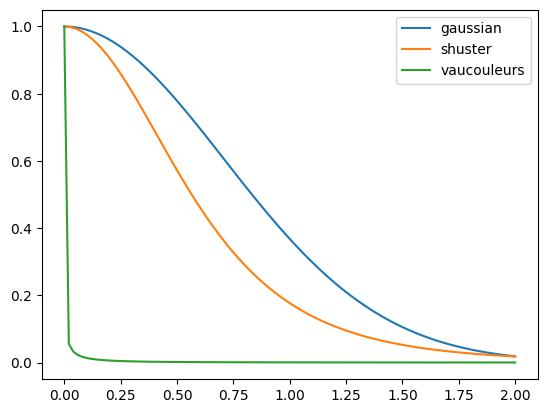

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def gaussian_profile(r2):
  return np.exp(-r2)

def schuster_profile(r2):
  return np.power(1+r2, -2.5)

#https://galaxiesbook.org/chapters/III-01.-Triaxial-Mass-Distributions.html
def vaucouleurs_profile(r):
  return np.exp(-7.67*(r**(1/4)-1))

def sersic_profile(r, b, n):
  return np.exp(-b*(r**(1/n)-1))

r = np.linspace(0., 2, num=100)
gp = gaussian_profile(r**2)
sp = schuster_profile(r**2)
vp = vaucouleurs_profile(r) / vaucouleurs_profile(0)

plt.plot(r, gp, label='gaussian')
plt.plot(r, sp, label='shuster')
plt.plot(r, vp, label='vaucouleurs')
plt.legend()